In [60]:
%matplotlib inline

# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.monitor import job_monitor
from qiskit.transpiler import PassManager, passes
from qiskit.compiler import transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

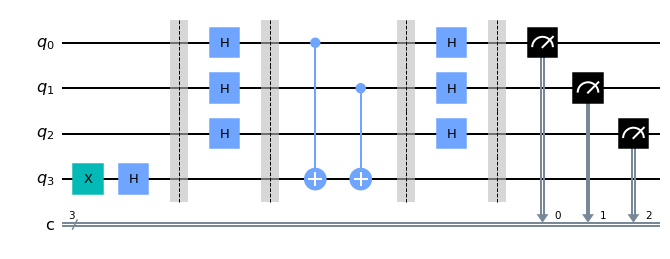

In [155]:
s = '011'
n = len(s)
qc = QuantumCircuit(n+1, n)
qc.x(n)
qc.h(n)
qc.barrier()
qc.h(range(n))
qc.barrier()
for i, value in enumerate(reversed(s)):
    if value == '1':
        qc.cx(i, n)
qc.barrier()
qc.h(range(n))
qc.barrier()
qc.measure(range(n),range(n))
qc.draw("mpl")

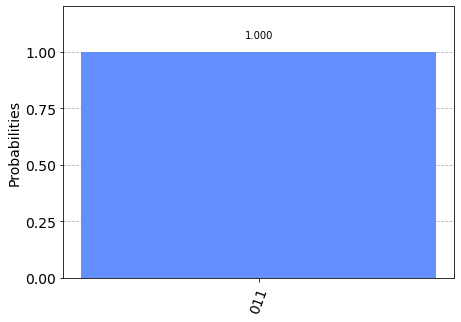

In [156]:
plot_histogram(execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=1000).result().get_counts())

In [157]:
from qiskit import IBMQ
#IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-sherbrooke', group='cmc-microsystems', project='optimization')
dev = provider.get_backend('ibmq_sydney')

In [158]:
print(dev.status().to_dict())

{'backend_name': 'ibmq_sydney', 'backend_version': '1.2.5', 'operational': True, 'pending_jobs': 28, 'status_msg': 'active'}


### In this tutorial, we show how to optimize quantum circuits, include noise on simulations and mitigate measurement errors

In order to introduce these concepts, we will use as example the Bernstein-Vazirani (BV) quantum algorithm. You can learn more aobut the BV algorithm on [qiskit textbook](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html).

In [58]:
secnumber = '011' # the hidden binary string

In [159]:
# The  Bernstein-Vazirani (BV) quantum algorithm
qc = QuantumCircuit(len(secnumber)+1,len(secnumber)) # defining quantum circuit

qc.h(range(len(secnumber)))
qc.x(len(secnumber))
qc.h(len(secnumber))

qc.barrier()

for ii, yesno in enumerate(reversed(secnumber)):
    if yesno == '1':
        qc.cx(ii,len(secnumber))

qc.barrier()
qc.h(range(len(secnumber)))
qc.barrier()

qc.measure(range(len(secnumber)),range(len(secnumber)))

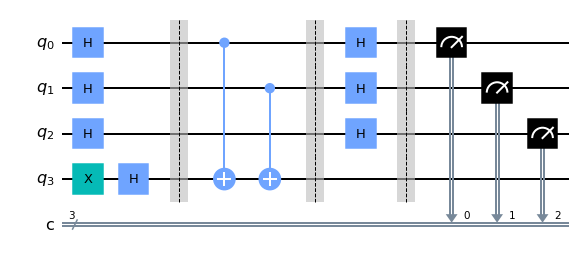

In [60]:
qc.draw('mpl')

We now simulate the above quantum algorighm on the qasm_simulator

{'011': 8000}


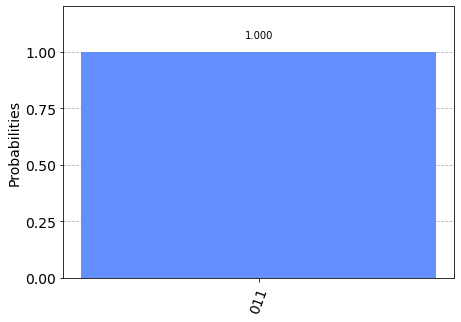

In [160]:
nshots = 8000
simulator = Aer.get_backend('qasm_simulator')
results = execute(qc, backend = simulator, shots = nshots).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

We submited the BV algo 8000 times to the quantum computer, and we got the correct result 100%.

Now that we know the BV algo works, let's run it on a 'real' quantum device.

Before running the BV algo, let's learn more about the real device

In [163]:
status = realdev.status() # Here we verify if the backend is active and operational.
status.to_dict()

{'backend_name': 'ibmq_sydney',
 'backend_version': '1.2.5',
 'operational': True,
 'pending_jobs': 28,
 'status_msg': 'active'}

In [164]:
config = realdev.configuration() # ADD COMMENTS
#print(config.to_dict())
props = realdev.properties()
#print(props.to_dict())

In [165]:
# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubits. It allows {3} shots. It allows {4} circuits in a single job."
      " It {6} OpenPulse programs. The basis gates supported on this device are {7}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                config.max_shots,
                config.max_experiments,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called ibmq_sydney, and is on version 1.2.5. It has 27 qubits. It allows 8192 shots. It allows 900 circuits in a single job. It supports OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].


In [ ]:
results1 = execute(qc, realdev, shots = nshots)
Job_id = results1.job_id()
print(f'--------------------------------\nJob ID: {Job_id}\n--------------------------------')
job_monitor(results1)

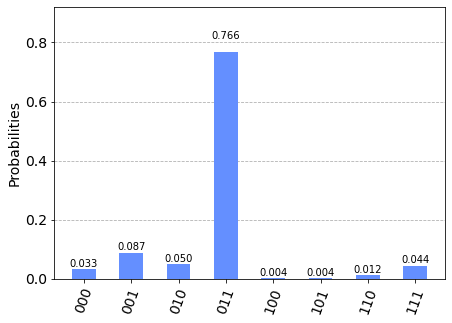

In [ ]:
counts1 = results1.result().get_counts()
plot_histogram(counts1)

We can also retrive the results uing the following command: 

{'000': 154, '001': 364, '010': 473, '011': 6613, '100': 13, '101': 112, '110': 24, '111': 247}


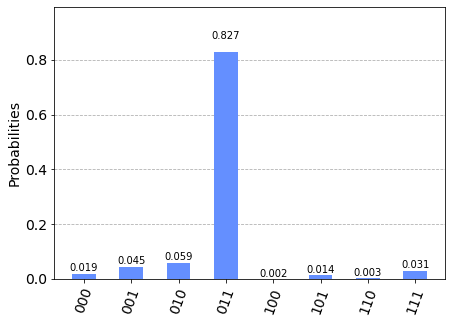

In [151]:
counts2 = provider.backend.retrieve_job(Job_id).result().get_counts() # it only works with real devices.
print(counts2)
plot_histogram(counts2)

In [152]:
print('The correct solution is found in', 100*counts1[secnumber]/nshots,'% of times.')

The correct solution is found in 76.6 % of times.


There are few questions that we need to answer:

1. Can we make the results from the simulation gets closer to the real device?
2. Can we improve the the real device's results?


Let's start answering the first question. The qasm_simulator has as main porpuse to simulate real devices. So, we can import the noise properties of real devices and incorporate them in the simulation.

{'01': 303, '11': 3630, '10': 236, '00': 3831}


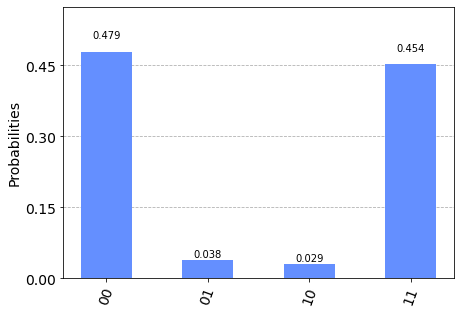

In [153]:
from qiskit.providers.aer.noise import NoiseModel

## Get the beckend's noise model
backend_noise = NoiseModel.from_backend(props)

counts3 = execute(qc,simulator,shots = nshots, noise_model=backend_noise).result().get_counts()
print(counts3)
plot_histogram(counts3)

Including the noise model on simulations brings the results close to the results obtanied with real devices, but it still far from reality.
Let's try to bring the results even closer. To this end, we include the same qubit coupling map and gate basis set.

{'101': 15, '001': 642, '110': 43, '100': 6, '010': 357, '011': 6691, '111': 149, '000': 97}


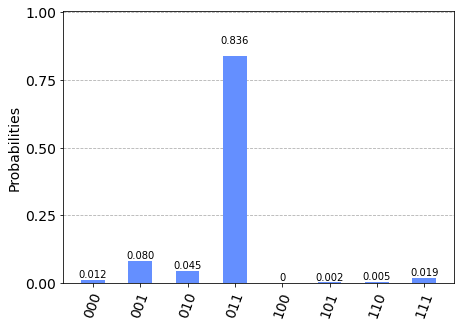

In [79]:
counts4 = execute(qc, simulator, shots = nshots, noise_model=backend_noise, 
                  coupling_map=config.coupling_map, basis_gates=config.basis_gates).result().get_counts()
print(counts4)
plot_histogram(counts4)

As we can see, the simulation results are now closer to the real device's results. This means that adding the device layout, basis gate and noise model has a strong effect on the results. The only thing we didn't check is the quantum circuit that is been executed.

To see which circuit is executed, we can use the `transpile` function. With the transpile function we have access to four levels of circuit optimization:

* optimization_level=0: just maps the circuit to the backend, with no explicit optimization (except whatever optimizations the mapper does).

* optimization_level=1: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

* optimization_level=2: medium-weight optimization, including a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships.

* optimization_level=3: heavy-weight optimization, which in addition to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

The default optimization level is 1.

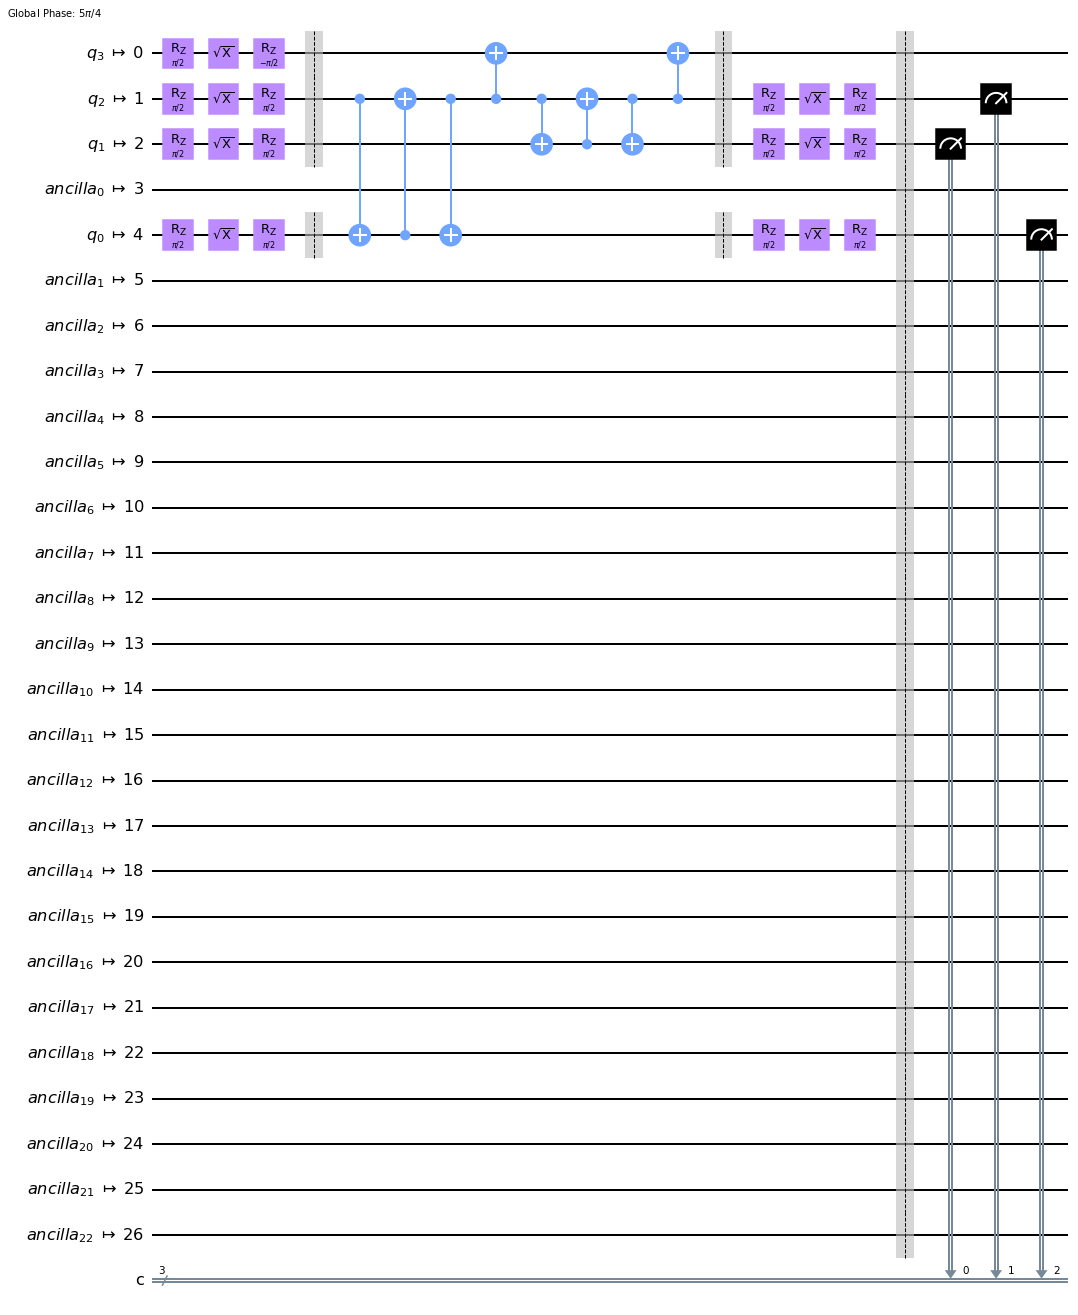

In [80]:
qct = transpile(qc, coupling_map=config.coupling_map, basis_gates=config.basis_gates)
qct.draw('mpl')

In [82]:
print(f'Depth of the original quantum circuit: {qc.depth()} - Depth of the transpiled qauntum circuit: {qct.depth()}')

Depth of the original quantum circuit: 6 - Depth of the transpiled qauntum circuit: 15


We can see that the computer quantum will execute a much deeper circuit than what we expected. The original quantum circuit has only two CNOT gates, but the transpiled circuit has 8 CNOT. In the original circuit, a cnot gate is applied between qubits 0 and 3, however, these qubits are not directly coupled. So, swap gates are added to perform a CNOT gate. Indeed, the coupling map is: 

In [146]:
print(config.coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


We see that qubit 2 is coupled to both qubit 1 and 3. Therfore, we could assign the virtual qubit 3 to the physical qubit 2. Indeed, to choose the optimal mapping, we can look at the CNOT error rates of the real device 

In [ ]:
# Print CNOT error for backend calibration data
cx_errors = list(map(lambda cm: props.gate_error("cx", cm), config.coupling_map))
for i in range(len(config.coupling_map)):
    print(f'      -> qubits {config.coupling_map[i]} CNOT error: {cx_errors[i]}')

Form the above results, we observe that lower CNOT errors are between paris [0,1] and [1,3]. Therefore, we use the following qubit layout:
    
* Virtual $q_0$ $\rightarrow$ Physical $q_2$.

* Virtual $q_1$ $\rightarrow$  Physical $q_4$.

* Virtual $q_2$ $\rightarrow$ Physical $q_1$.

* Virtual $q_3$ $\rightarrow$  Physical $q_3$.

The optimal qubit layout is

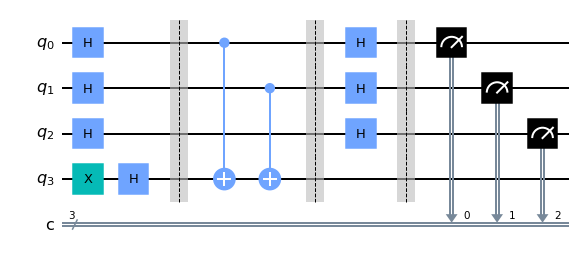

In [22]:
qc.draw('mpl')

In [149]:
# when a list argument is used, virtual qubits are ordered
qlayout = [0,4,3,1]
# [q0,q1,q2,q3] qubit order

In [ ]:
qctl = transpile(qc, coupling_map=config.coupling_map, basis_gates=config.basis_gates, initial_layout=qlayout)
#qctl = transpile(qc, coupling_map=config.coupling_map, basis_gates=config.basis_gates, initial_layout=qlayout)
qctl.draw('mpl')

Note that the transpiled circuit is very similar to ideal quantum circuit. We can check the depth now:

In [92]:
print(f'Depth of the original quantum circuit: {qc.depth()} - Depth of the transpiled qauntum circuit: {qctl.depth()}')

Depth of the original quantum circuit: 6 - Depth of the transpiled qauntum circuit: 11


In the transpiled quantum circuit, we just have 2 CNOTs gates and depth is much closer to the ideal quantum circuit. Therefore, by assing virtual qubits to real physical qubits, we were able to reduce the circuit depth.

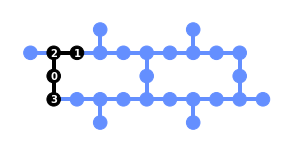

In [147]:
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(qctl,realdev)

We can now see how the different level of optimization will affect the circuit depth

In [94]:
qctl0 = transpile(qc, coupling_map=config.coupling_map, basis_gates=config.basis_gates, initial_layout=qlayout,optimization_level=0)
qctl1 = transpile(qc, coupling_map=config.coupling_map, basis_gates=config.basis_gates, initial_layout=qlayout,optimization_level=1)
qctl2 = transpile(qc, coupling_map=config.coupling_map, basis_gates=config.basis_gates, initial_layout=qlayout,optimization_level=2)
qctl3 = transpile(qc, coupling_map=config.coupling_map, basis_gates=config.basis_gates, initial_layout=qlayout,optimization_level=3)

In [95]:
print(f'Depth for transpiled circuits with optimization levels {0,1,2,3} respectively: ({qctl0.depth()}, {qctl1.depth()}, {qctl2.depth()}, {qctl3.depth()})')

Depth for transpiled circuits with optimization levels (0, 1, 2, 3) respectively: (13, 11, 11, 17)


So, using optimization levels 1 to 3, gives the same circuit detph. We now execute this circuit in the simulator all features of the device.

{'100': 1, '110': 5, '001': 718, '101': 68, '010': 185, '011': 6801, '000': 67, '111': 155}


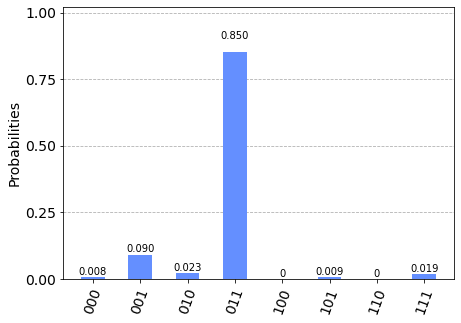

In [97]:
res_tr = execute(qctl2, simulator, shots = nshots, noise_model=backend_noise, 
                  coupling_map=config.coupling_map, basis_gates=config.basis_gates)

counts_tr1 = res_tr.result().get_counts(qctl1)

print(counts_tr1)
plot_histogram(counts_tr1)

Which is better than what we obtained from the real device and the simulation with device properties. We now execute the above circuit in the real device.

In [98]:
results_tr = execute(qctl2, realdev, shots = nshots, optimization_level=0)
Job_id = results_tr.job_id()
print(f'--------------------------------\nJob ID: {Job_id}\n--------------------------------')
job_monitor(results_tr)

--------------------------------
Job ID: 6168353dab11306bde045784
--------------------------------
Job Status: job has successfully run


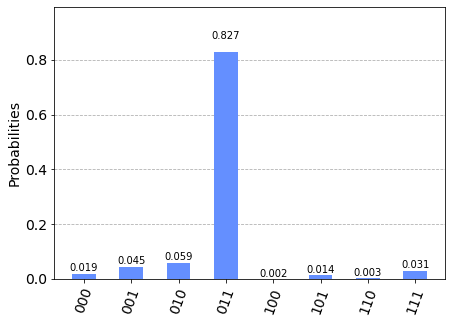

In [99]:
counts_tr = results_tr.result().get_counts()
plot_histogram(counts_tr)

Therefore, by carefully analyzing the quantum circuit and assign virtual qubits to physical qubits with lowest CNOT errors, we were able to improve the real device's results. However, the results still far from what we obtained with the ideal circuit. We will now try to further improve the real device's results by mitigating measurments erros. More details on measurement error mitigation can be 
found [here](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html).

We will create a measurement filter to be applied to our resutls.





**MITIGATION**

In [171]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [172]:
qr = QuantumRegister(3) # quantum circuit with three qubits
qulayout = [0,1,2]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qulayout, qr=qr, circlabel='mecal')

This creates a set of circuits to take measurements for each of the 2^3 = 8 basis states for three qubits.

Number of circuits: 8


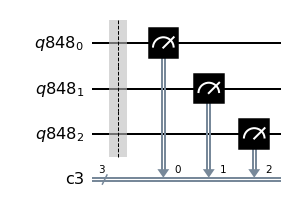

In [169]:
print(f'Number of circuits: {len(meas_calibs)}')
meas_calibs[0].draw("mpl")

The next step is to create the matrix $M_{noise}$ such that $R_{ideal} = M_{noise} R_{device}$. 

In [173]:
# the qubit layout has to be same that we are using for measurements. Since, we meausere the physical qubits 0, 1 and 3, we have
qcali_layout = [1,2,4] # physical qubits that are measured.

Noise = execute(meas_calibs, simulator, shots=8192, noise_model=backend_noise, coupling_map=config.coupling_map, basis_gates=config.basis_gates, 
                initial_layout=qcali_layout).result()

We now create a measurement filter

In [178]:
meas_fitter = CompleteMeasFitter(Noise, state_labels)

In [179]:
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

We apply the filter to the simulator results.

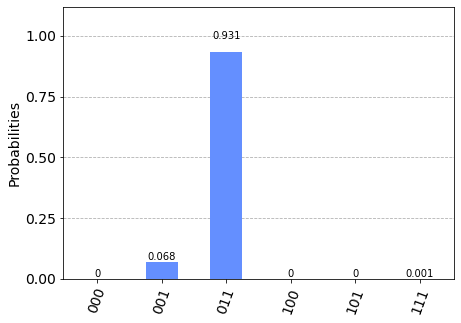

In [181]:
mfilter = meas_fitter.filter # # Get the filter object to apply to real device results
counts_mit = mfilter.apply(res_tr.result()).get_counts()
plot_histogram(counts_mit)

Finally, we apply the filter to the real device's results.

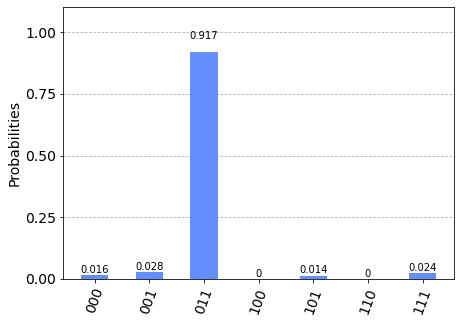

In [182]:
countsred_mit = mfilter.apply(results_tr.result()).get_counts()
plot_histogram(countsred_mit)

In [183]:
print('As expected the results are improved, i.e., by mitigating measurement erros, we find the correct solution', 100*countsred_mit[secnumber]/nshots,'% of times.')

As expected the results are improved, i.e., by mitigating measurement erros, we find the correct solution 91.7294030720104 % of times.


**MITIGATION ERROR**

In [38]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [68]:
noise_model = get_noise(0.01)

In [70]:
aer_sim = Aer.get_backend('aer_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)
    qc.measure([0,1], [0,1])
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    print(state, 'becomes', counts)

00 becomes {'00': 10000}
01 becomes {'01': 10000}
10 becomes {'10': 10000}
11 becomes {'11': 10000}


In [41]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [77]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [ ]:
for circuit in meas_calibs:
    print('Circuit: ', circuit.name)
    print(circuit)

In [79]:
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()

In [80]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [86]:
noise_model = get_noise(0.3)

In [87]:
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

The next step is to create the matrix $M_{noise}$ such that $R_{ideal} = M_{noise} R_{device}$. 

In [88]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0, 1], [0, 1])

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'11': 2912, '01': 2061, '00': 2898, '10': 2129}


In [89]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

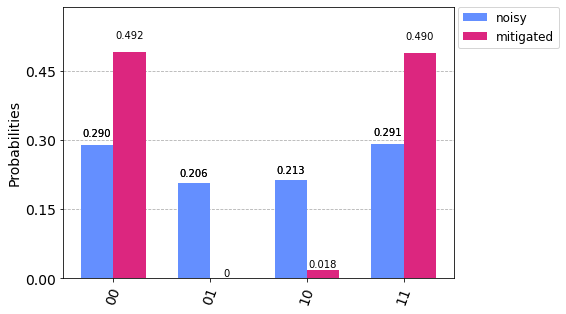

In [90]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

**REAL DEVICE**

In [91]:
props = realdev.properties()
backend_noise = NoiseModel.from_backend(props)

In [100]:
qc = QuantumCircuit(2,2)
qc.x(0)
qc.x(1)
qc.measure([0, 1], [0, 1])

t_qc = transpile(qc, realdev)
qobj = assemble(t_qc, shots=8192)
#results_realdev = realdev.run(qobj, noise_model=backend_noise, shots=8192).result()
results_realdev = realdev.run(qobj, noise_model=backend_noise, shots=8192).result()
noisy_counts_realdev = results_realdev.get_counts()
print(noisy_counts_realdev)

{'00': 12, '01': 307, '10': 237, '11': 7636}


In [101]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results_realdev = meas_filter.apply(results_realdev)
mitigated_counts_realdev = mitigated_results_realdev.get_counts()

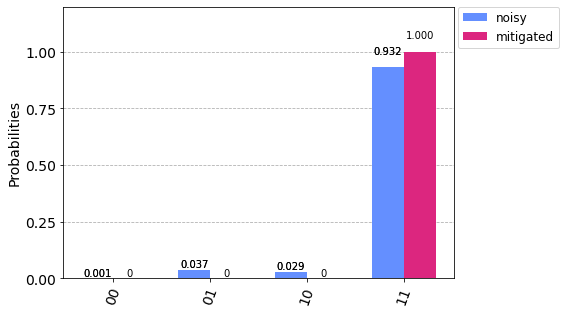

In [102]:
from qiskit.visualization import plot_histogram 
plot_histogram([noisy_counts_realdev, mitigated_counts_realdev], legend=['noisy', 'mitigated'])